# Project 2 - Autonomous Driving

By Laura Madrid & Lucas Noritomi-Hartwig

Autonomous driving is one of the major research venues these days. A lot of
effort is devoted to it by both the academics as well as industry. In this
project you'll familiarize yourself with some of the most important problems
that arise in the field of autonomous driving.

The input to your algorithm is a stereo image pair and the camera parameters.
You will also have available a set of training images where the cars have been
annotated with 2D bounding boxes as well as viewpoint. Furthermore, you'll have
a few images where the road has been annotated. Here are the tasks to solve:

### 6. Detect cars in the image. You can use the pre-trained models available here: http://kitti.is.tue.mpg.de/kitti/models_lsvm.zip, and detection code available here: http://www.cs.berkeley.edu/~rbg/latent/. Alternatively, you can use other detectors available online such as SSD, Fast(er)-RCNN, etc.

#### a. Take the pertaining data from the KITTI Dataset (the class of object and it's bounding box) to train the YOLOv8 model!
We originally took the KITTI folders 'data_object_label_2' and 'data_object_image_2' but that was 7480 images. Due to time constraints we reduced the dataset to just the image IDS that match the images from project2/train_angle/image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from pathlib import Path
from tqdm.auto import tqdm
from types import SimpleNamespace
import os
from PIL import Image
import csv
from pathlib import Path
import shutil
import matplotlib.patches as patches

In [ ]:
# Initialize the meta variable with directory paths
meta = SimpleNamespace(base_dir=Path('object_detection_dataset'))
meta.label_path = meta.base_dir / 'training' / 'labels'
meta.img_path = meta.base_dir / 'training' / 'images'
image_folder = SimpleNamespace(base_dir=Path('object_detection_dataset')).base_dir / 'image'

# Create a set of IDs from the files in the 'image' folder
image_ids = set(f.stem for f in image_folder.glob('*.jpg'))

# Filter label files in data_object_label_2 and remove files that are not in image_ids
for label_file in meta.label_path.glob('*.txt'):
    label_id = label_file.stem
    if label_id not in image_ids:
        # Remove the file if its ID is not in image_ids
        label_file.unlink()

# Filter image files in data_object_image_2 and remove files that are not in image_ids
for image_file in meta.img_path.glob('*.png'):
    image_id = image_file.stem
    if image_id not in image_ids:
        # Remove the file if its ID is not in image_ids
        image_file.unlink()

print("Folders have been filtered based on image folder IDs.")

Folders have been filtered based on image folder IDs.


In [ ]:
# Define the base directory and paths
meta = SimpleNamespace(base_dir=Path('object_detection_dataset'))
meta.label_path = meta.base_dir / 'training' / 'labels'
meta.img_path = meta.base_dir / 'training' / 'images'

# Define the output directory for YOLOv8 formatted labels
output_dir = meta.base_dir /'yolov8_labels'
os.makedirs(output_dir, exist_ok=True)

In [2]:
# Class mapping from class name to YOLOv8 class ID
class_mapping = {
    'Car': 0,
    'Pedestrian': 1,
    'Van': 2,
    'Cyclist': 3,
    'Truck': 4,
    'Misc': 5,
    'Tram': 6,
    'Person_sitting': 7,
    'DontCare': 8
}

# Define the mapping of class names to colors
class_colors = {
    'Car': 'blue',
    'Pedestrian': 'green',
    'Van': 'red',
    'Cyclist': 'purple',
    'Truck': 'orange',
    'Misc': 'yellow',
    'Tram': 'cyan',
    'Person_sitting': 'magenta',
    'DontCare': 'gray'
}

In [ ]:
# Convert a bounding box from KITTI format to YOLOv8 format
def convert_bbox_kitti_to_yolov8(bbox, img_width, img_height):
    xmin, ymin, xmax, ymax = bbox
    width = xmax - xmin
    height = ymax - ymin
    center_x = xmin + width / 2
    center_y = ymin + height / 2

    # Normalize the values by the image dimensions
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    return center_x, center_y, width, height

In [ ]:
# Convert a bounding box from KITTI format to YOLOv8 format
def convert_bbox_kitti_to_yolov8(bbox, img_width, img_height):
    xmin, ymin, xmax, ymax = bbox
    width = xmax - xmin
    height = ymax - ymin
    center_x = xmin + width / 2
    center_y = ymin + height / 2

    # Normalize the values by the image dimensions
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    return center_x, center_y, width, height

In [ ]:
# Function to read KITTI labels and convert them to YOLOv8 format
def convert_labels_to_yolov8(label_path, img_path, output_path):
    img = Image.open(img_path)
    img_width, img_height = img.size

    yolo_labels = []

    with open(label_path) as file:
        reader = csv.reader(file, delimiter=' ')
        for row in reader:
            label = row[0]  # The object type
            if label == 'DontCare' or label == 'Misc':
                # Skip 'DontCare' and 'Misc' labels
                continue

            # Parse the bounding box
            xmin, ymin, xmax, ymax = map(float, row[4:8])
            bbox = (xmin, ymin, xmax, ymax)

            # Convert the bounding box to YOLOv8 format
            center_x, center_y, width, height = convert_bbox_kitti_to_yolov8(bbox, img_width, img_height)

            # Get the class ID
            class_id = class_mapping.get(label, -1)

            if class_id == -1:
                # Skip labels with unknown classes
                continue

            # Append the YOLOv8 label
            yolo_labels.append(f"{class_id} {center_x} {center_y} {width} {height}")
    # Write the YOLOv8 labels to a new file
    with open(output_path, 'w') as out_file:
        out_file.write("\n".join(yolo_labels))

In [3]:
# To test that we got the correct points before training the YOLOV8 model
# Function to plot bounding boxes on the image
def plot_bounding_boxes(sample_id):
    # Define the paths for the YOLOv8 formatted label file and the test image
    yolo_label_path = output_dir / f"{sample_id}.txt"
    img_path = meta.img_path / f"{sample_id}.png"

    # Open the image
    img = Image.open(img_path)
    img_width, img_height = img.size

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)

    # Read the YOLOv8 formatted label file
    with open(yolo_label_path, 'r') as file:
        # Parse each line in the label file
        for line in file:
            # Split the line into values
            values = line.split()

            # Parse the class ID and bounding box values
            class_id = int(values[0])
            center_x = float(values[1])
            center_y = float(values[2])
            width = float(values[3])
            height = float(values[4])

            # Convert YOLOv8 format bounding box to image coordinates
            xmin = (center_x - width / 2) * img_width
            ymin = (center_y - height / 2) * img_height
            xmax = (center_x + width / 2) * img_width
            ymax = (center_y + height / 2) * img_height

            # Find the class name using the class ID
            class_name = next((name for name, id in class_mapping.items() if id == class_id), "Unknown")

            # Get the color for the class
            color = class_colors.get(class_name, "red")

            # Create a rectangle patch
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor=color, facecolor='none')

            # Add the rectangle to the plot
            ax.add_patch(rect)

            # Add the class name as text on the plot
            ax.text(xmin, ymin - 5, f"{class_name}", color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

    # Display the plot
    plt.show()

In [ ]:
# Define the output directory for YOLOv8 formatted labels
output_dir = meta.base_dir /'yolov8_labels'
output_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# TESTING IMAGE
sample_id = '002911'

# Paths for labels, images, and output
label_path = meta.label_path / f"{sample_id}.txt"
img_path = meta.img_path / f"{sample_id}.png"
output_path = output_dir / f"{sample_id}.txt"

print(label_path)  # Print the path of the label file
print(img_path)  # Print the path of the image file
print(output_path)  # Print the path of the YOLOv8 label file

# Convert the labels
convert_labels_to_yolov8(label_path, img_path, output_path)

# Call the function to plot bounding boxes on the test image
plot_bounding_boxes(sample_id)

In [ ]:
# Iterate through the KITTI label files
for label_file in os.listdir(meta.label_path):
    if label_file.startswith('.'):
        continue
    print(label_file)
    # Get the paths for the label and image
    label_path = meta.label_path / label_file
    sample_id = label_file.split('.')[0]  # Get the sample ID (file name without extension)
    # print(sample_id)
    img_path = meta.img_path / f"{sample_id}.png"

    # Define the output path for the YOLOv8 label file
    output_path = Path(output_dir) / f"{sample_id}.txt"

    # Convert the labels to YOLOv8 format
    convert_labels_to_yolov8(label_path, img_path, output_path)

print("Conversion to YOLOv8 format completed.")

002041.txt
004154.txt
006025.txt
006018.txt
007474.txt
006568.txt
005897.txt
006150.txt
006634.txt
006191.txt
004962.txt
004382.txt
005249.txt
003837.txt
004618.txt
002269.txt
007463.txt
003605.txt
004624.txt
005248.txt
002902.txt
007275.txt
002494.txt
002872.txt
005847.txt
006547.txt
007301.txt
006750.txt
006022.txt
002683.txt
004966.txt
002442.txt
006632.txt
005844.txt
004347.txt
004353.txt
002911.txt
006587.txt
001773.txt
001996.txt
005514.txt
005104.txt
002119.txt
003978.txt
006141.txt
006169.txt
006132.txt
003704.txt
006867.txt
003274.txt
003857.txt
006912.txt
002235.txt
005943.txt
003301.txt
003077.txt
005174.txt
006509.txt
002009.txt
005955.txt
005216.txt
006938.txt
003840.txt
002586.txt
004875.txt
002544.txt
004294.txt
006468.txt
001844.txt
003064.txt
001840.txt
004086.txt
007174.txt
003892.txt
006733.txt
005038.txt
005616.txt
001699.txt
005400.txt
005358.txt
007003.txt
003271.txt
005628.txt
002033.txt
006719.txt
003107.txt
003852.txt
006042.txt
006532.txt
004325.txt
003516.txt

#### b. Train the model

In [3]:
%pip install ultralytics -q
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 7.6 MB/s eta 0:00:00


In [4]:
from google.colab import drive

# Mount Google Drive to /content/drive
drive.mount('/content/drive/')

# After mounting, you can access files from your Google Drive like this:
!ls /content/drive/MyDrive/CSC420_FINAL

Mounted at /content/drive/
autonomous_driving_part2.ipynb	object_detection_dataset


In [5]:
# CHECKING THAT THE PATH STRUCTURE IS CORRECT
base_dir = Path(' /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset')
img_path_train = base_dir / 'training' / 'images' # training images (148 images)
label_path_train = base_dir / 'training' / 'labels' # training images

img_path_validation = base_dir / 'validation' / 'images' # validation images (30 images)
label_path_validation = base_dir / 'validation' / 'labels' # validation images

img_path_testing = base_dir / 'test' / 'images' # validation images (17 images .. 10% for this and 90% for training)
label_path_testing = base_dir / 'test' / 'labels' # validation images

In [6]:
# checking that paths are correct:
print(img_path_train)
print(label_path_train)

print(img_path_validation)
print(label_path_validation)

print(img_path_testing)
print(label_path_testing)

 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/training/images
 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/training/labels
 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/validation/images
 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/validation/labels
 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images
 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/labels


In [7]:
print(class_mapping)

{'Car': 0, 'Pedestrian': 1, 'Van': 2, 'Cyclist': 3, 'Truck': 4, 'Misc': 5, 'Tram': 6, 'Person_sitting': 7, 'DontCare': 8}


In [8]:
# paths used for the model!
train_path = base_dir / 'training'
valid_path = base_dir / 'validation'

print(train_path)
print(valid_path)

 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/training
 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/validation


In [9]:
yaml_classes = '\n'.join(f'- {class_name}' for class_name in class_mapping.keys())
print(yaml_classes)

- Car
- Pedestrian
- Van
- Cyclist
- Truck
- Misc
- Tram
- Person_sitting
- DontCare


In [10]:
yaml_file_content = f"""names:
{yaml_classes}
nc: {len(class_mapping)}
train: {train_path}
val: {valid_path}
"""
print(yaml_file_content)

names: 
- Car
- Pedestrian
- Van
- Cyclist
- Truck
- Misc
- Tram
- Person_sitting
- DontCare
nc: 9
train:  /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/training
val:  /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/validation



In [11]:
# CREATE YAML FILE
data_yaml_file_path = base_dir / 'detection_kitti.yaml'
import os

# Ensure the directory for the YAML file exists
directory = os.path.dirname(data_yaml_file_path)
os.makedirs(directory, exist_ok=True)

# Write the YAML file content to the specified path
with open(data_yaml_file_path, 'w') as file:
    file.write(yaml_file_content)

In [12]:
!ls -a /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset

detection_kitti.yaml  image		     MODEL_1_VIEWPOINT	    test      validation
.DS_Store	      MODEL_1_CAR_DETECTION  MODEL_2_CAR_DETECTION  training  yolov8_labels


In [15]:
# Load the Original YOLO model to train on our own data
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 74.5MB/s]


In [ ]:
train_results = model.train(
    data='/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/detection_kitti.yaml',
    epochs=20,
    patience=3,
    mixup=0.1,
    project='/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_2_CAR_DETECTION',
    device='cpu',  # Use 'cpu' to train on the CPU
    batch=8  # Adjust batch size as necessary
)

In [20]:
valid_results = model.val()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/validation/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


                   all         30        206      0.851      0.236      0.278      0.181
                   Car         30        168      0.571      0.792      0.784       0.53
            Pedestrian         30          5          1          0          0          0
                   Van         30         28      0.686      0.391      0.549      0.339
               Cyclist         30          4          1          0     0.0432     0.0294
                 Truck         30          1          1          0     0.0126    0.00756
Speed: 3.4ms preprocess, 93.6ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_2/train2


In [13]:
# load the trained YOLO model
model = YOLO('/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_2_CAR_DETECTION/train/weights/best.pt')

In [14]:
print(img_path_testing)

 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images


In [15]:
# Function to display image with predictions
def display_image_with_predictions(img_file, results):
    # Load original image file and out it in the correct format
    img = Image.open(img_file)
    img_np = np.array(img)

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(img_np)

    # Go through the results
    for result in results:
        # Go through the predicted boxes
        for box in result.boxes:
            # Get the box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()

            # Get the class ID and confidence
            class_id = int(box.cls.item())
            confidence = box.conf.item()

            # Map the class ID to its class name and color from dictionary mentioned above
            class_name = next(key for key, value in class_mapping.items() if value == class_id)
            color = class_colors[class_name]

            # Draw the bounding box with the corresponding color on the image
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # Add text label with class name and confidence
            label = f'{class_name} {confidence:.2f}'
            # Add the class name as text on the plot
            ax.text(x1, y1 - 5, f"{label}", color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

    # Display the plot
    plt.show()


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images/001699.png: 224x640 8 Cars, 217.0ms
Speed: 15.3ms preprocess, 217.0ms inference, 3149.1ms postprocess per image at shape (1, 3, 224, 640)


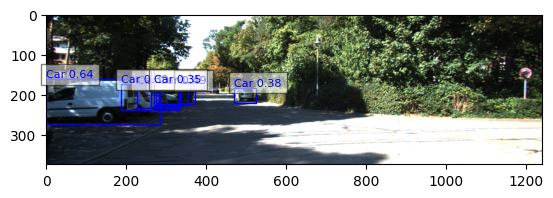

In [16]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images/001699.png'
results = model.predict(img_file)

# display the image with predictions
display_image_with_predictions(img_file, results)


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images/001773.png: 224x640 10 Cars, 73.0ms
Speed: 2.4ms preprocess, 73.0ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)


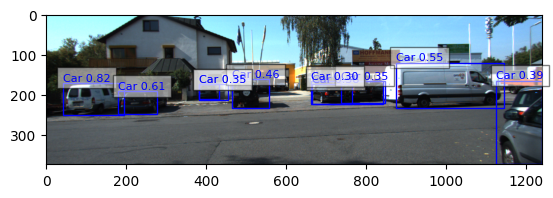

In [17]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images/001773.png'
results = model.predict(img_file)

# display the image with predictions
display_image_with_predictions(img_file, results)


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images/002112.png: 224x640 4 Cars, 75.5ms
Speed: 1.6ms preprocess, 75.5ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)


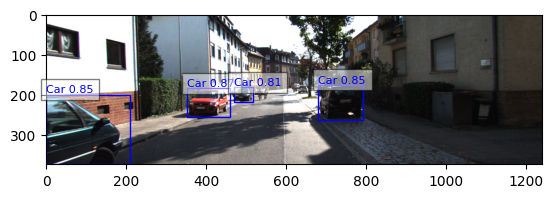

In [18]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images/002112.png'
results = model.predict(img_file)

# display the image with predictions
display_image_with_predictions(img_file, results)

#### Testing detection on other cases
With pedestrians, cyclists, vans , more cars..


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/001277.png: 224x640 5 Cars, 83.2ms
Speed: 3.0ms preprocess, 83.2ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)


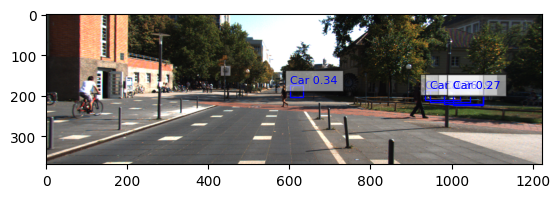

In [19]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/001277.png'
results = model.predict(img_file)

# display the image with predictions
display_image_with_predictions(img_file, results)


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/001267.png: 224x640 7 Cars, 78.3ms
Speed: 1.9ms preprocess, 78.3ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)


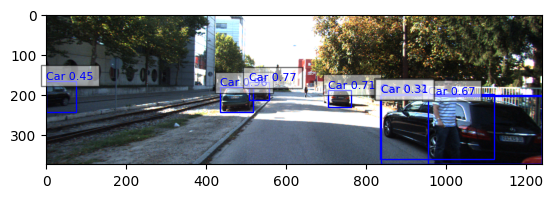

In [20]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/001267.png'
results = model.predict(img_file)

# display the image with predictions
display_image_with_predictions(img_file, results)


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/001244.png: 224x640 (no detections), 73.0ms
Speed: 2.5ms preprocess, 73.0ms inference, 0.5ms postprocess per image at shape (1, 3, 224, 640)


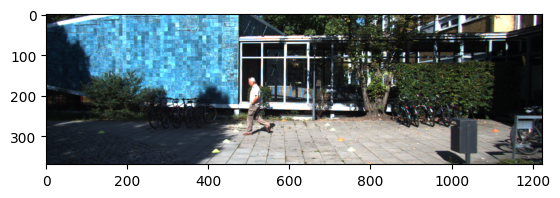

In [21]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/001244.png'
results = model.predict(img_file)

# display the image with predictions
display_image_with_predictions(img_file, results)


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/000051.png: 224x640 2 Cars, 1 Van, 83.5ms
Speed: 3.7ms preprocess, 83.5ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 640)


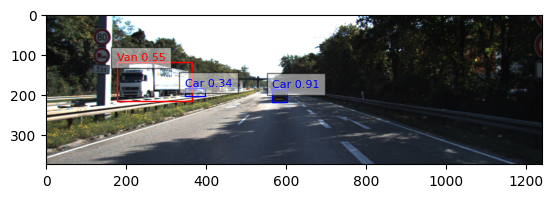

In [22]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/000051.png'
results = model.predict(img_file)

# display the image with predictions
display_image_with_predictions(img_file, results)

### 7. Train a classifier that predicts viewpoint for each car. The viewpoint labels are in 30◦ increments, thus train a 12-class classifier.

In [23]:
import os
import cv2
import numpy as np
from skimage import io
import scipy.io as sio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation, GaussianNoise

In [24]:
# IN THIS CASE WE USE old_labels which are the original .txt labels from the kitti dataset and contain the yaw angle which tell us the viewpoint of the car!
base_dir = Path('/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset')
img_path_train = base_dir / 'training' / 'images' # training images (148 images)
label_path_train = base_dir / 'training' / 'old_labels' # training labels

img_path_validation = base_dir / 'validation' / 'images' # validation images (30 images)
label_path_validation = base_dir / 'validation' / 'old_labels' # validation labels

img_path_testing = base_dir / 'test' / 'images' # validation images (17 images .. 10% for this and 90% for training)
label_path_testing = base_dir / 'test' / 'old_labels' # validation labels

In [25]:
def read_files(image_path, label_path):
    # Read images and labels
    images = []
    annotations = []
    for path in os.listdir(image_path):
        img_full_path = os.path.join(image_path, path)
        if "DS_Store" not in img_full_path:
            img = io.imread(img_full_path)
            images.append(img)

            num = path.split('.')[0]
            label_full_path = os.path.join(label_path, num + '.txt')
            with open(label_full_path, 'r') as f:
                annotation = f.readline().strip().split()  # Read the first line
                annotations.append(annotation)

    return images, annotations

In [26]:
def get_labels(rotation_y):
    # Bin rotation_y values into 12 classes corresponding to 30° increments
    bins = np.linspace(-np.pi, np.pi, 12 + 1)  # 12 classes, so we have 12 + 1 edges
    label = np.digitize(float(rotation_y), bins) - 1  # Subtract 1 to start from 0
    return label

In [27]:
def filter_vehicles(annotation, img, desired_height=100, desired_width=100):
    # Extract relevant information from annotations
    object_type = annotation[0]
    rotation_y = annotation[-1]

    # Check if the object is a vehicle
    # if object_type == 'Car' or object_type == 'Van' or object_type == 'Truck':
    if object_type in ["Car", "Van", "Truck"]:
        # Convert rotation_y to label
        label = get_labels(rotation_y)
        # Extract bounding box coordinates
        left, top, right, bottom = map(float, annotation[4:8])
        left, top, right, bottom = round(left), round(top), round(right), round(bottom) # Rounding to nearest integer instead of truncating
        # Crop car patch from image
        patch = img[top:bottom, left:right]
        # Resize patch to a fixed size
        patch = cv2.resize(patch, (desired_width, desired_height))
        # Calculate height and width of bounding box
        height = bottom - top
        width = right - left
        return height, width, patch, label  # Return height, width, patch, and label
    else:
        return 0, 0, None, None  # Return zeros and None for patch and label if object is not a car, van, truck


In [28]:
def load_data(image_path, label_path):
    # Read in images and labels
    images, annotations = read_files(image_path, label_path)

    # Store patches, heights, widths, and labels
    patches_list, heights_list, widths_list, labels_list = [], [], [], []
    for annotation, img in zip(annotations, images):
        height, width, patch, label = filter_vehicles(annotation, img)
        if label is not None and patch is not None:  # Guarantees car, van, truck
            heights_list.append(height)
            widths_list.append(width)
            patches_list.append(patch)
            labels_list.append(label)

    # Convert lists to numpy arrays
    patches_array = np.array(patches_list)
    heights_array = np.array(heights_list)
    widths_array = np.array(widths_list)
    labels_array = np.array(labels_list)

    return patches_array, heights_array, widths_array, labels_array


In [29]:
# Load training data
train_patches, train_heights, train_widths, train_labels = load_data(img_path_train, label_path_train)

# Load validation data
validation_patches, validation_heights, validation_widths, validation_labels = load_data(img_path_validation, label_path_validation)

# Load testing data
test_patches, test_heights, test_widths, test_labels = load_data(img_path_testing, label_path_testing)


In [31]:
print("TRAIN LABELS")
print(train_labels)
angle_occurrences = {}
for label in train_labels:
  if label in angle_occurrences:
    angle_occurrences[label] += 1
  else:
    angle_occurrences[label] = 0

print("Angle: occurences")
print(angle_occurrences)

TRAIN LABELS
[ 3  8  8  8  2  2  8  8  8  8  8 11  8  8  9 10  9  8  2  2  8  8  2  8  3  2  2  3  3  2  8  3  2  2  2  2  2  2  2  3  3  8  3  8  0 11  3 11  3  3  8 11  3 11  2  3  8  2  2  2  2  2  2  2  2 11 11 11 11 11  6  9  8  8  8  4  7  3 11 11  3  3  9  9  8  3  2  8  9  3  2 11 11 11 11 11 11 11 11  0  8  8  9  8  8  3
  3  8  9  3  2  9  2  8  8  2  9  9  9  9  3  9  3  3  9  0  8  8  8  8  8  8  9  8  9  0  8  8 11  8  9  8]
Angle: occurences
{3: 23, 8: 41, 2: 28, 11: 20, 9: 17, 10: 0, 0: 3, 6: 0, 4: 0, 7: 0}


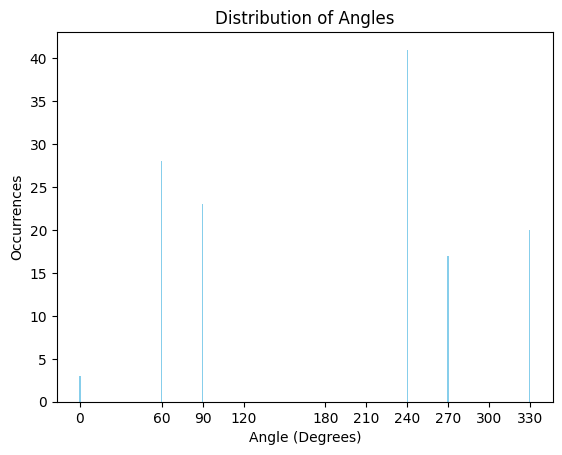

In [33]:
# Create a list of angles based on the keys of angle_occurrences (index*30 degree increments)
angles = [angle * 30 for angle in angle_occurrences.keys()]

# Plot histogram
plt.bar(angles, angle_occurrences.values(), color='skyblue')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Occurrences')
plt.title('Distribution of Angles')
plt.xticks(angles)
plt.show()

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate

In [35]:
# MODEL 1
def create_viewpoint_model(image_shape, num_classes):
    # Define input layers for images, heights, and widths
    input_image = Input(shape=image_shape, name='image_input')
    input_height = Input(shape=(1,), name='height_input')
    input_width = Input(shape=(1,), name='width_input')

    # CNN layers for image data
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)

    # Fully connected layers for height and width
    y = Dense(32, activation='relu')(input_height)
    y = Dense(32, activation='relu')(y)

    z = Dense(32, activation='relu')(input_width)
    z = Dense(32, activation='relu')(z)

    # Concatenate the outputs of CNN and fully connected layers
    merged = concatenate([x, y, z])

    # Dense layers for classification
    merged = Dense(512, activation='relu')(merged)
    merged = Dropout(0.5)(merged)
    output = Dense(num_classes, activation='softmax')(merged)

    # Define the model
    model = Model(inputs=[input_image, input_height, input_width], outputs=output)

    return model

In [85]:
# MODEL 1 training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
def train_model(image_path, label_path):
    # Load the data
    train_patches, train_heights, train_widths, train_labels = load_data(image_path, label_path)

    # Define image shape
    image_shape = train_patches[0].shape

    # Define number of classes
    num_classes = 12  # Assuming 12 classes for viewpoint

    # Create the model
    model = create_viewpoint_model(image_shape, num_classes)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks to save the best model during training
    # Implemented early stopping, after 10 iterations of no improvement you sto!
    callbacks = [
      EarlyStopping(patience=10, verbose=1),
      ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
      ModelCheckpoint('/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_2_VIEWPOINT', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    ]


    # checkpoint = ModelCheckpoint('/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_1_VIEWPOINT', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # Train the model
    history = model.fit(x=[train_patches, train_heights, train_widths], y=train_labels,
                        batch_size=10, epochs=100, validation_split=0.1, callbacks=callbacks)

    return history

In [97]:
# MODEL 2: Included a few layers to see if I could improve the model
from keras.optimizers import Adam
from keras.regularizers import l2
def create_viewpoint_model(image_shape, num_classes):
    input_image = Input(shape=image_shape, name='image_input')
    input_height = Input(shape=(1,), name='height_input')
    input_width = Input(shape=(1,), name='width_input')

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_image)
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)

    y = Dense(64, activation='relu')(input_height)
    y = Dense(64, activation='relu')(y)

    z = Dense(64, activation='relu')(input_width)
    z = Dense(64, activation='relu')(z)

    merged = concatenate([x, y, z])

    merged = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(merged)
    merged = Dropout(0.5)(merged)
    output = Dense(num_classes, activation='softmax')(merged)

    model = Model(inputs=[input_image, input_height, input_width], outputs=output)

    return model

In [98]:
# Define image shape: you can take the first patches shape since all patches have the same shape
image_shape = train_patches[0].shape

# Define number of viewpoint classes (12 classes for 30° increments)
num_classes = 12

# Create the model
model = create_viewpoint_model(image_shape, num_classes)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_54 (Conv2D)          (None, 100, 100, 32)         896       ['image_input[0][0]']         
                                                                                                  
 conv2d_55 (Conv2D)          (None, 98, 98, 32)           9248      ['conv2d_54[0][0]']           
                                                                                                  
 max_pooling2d_27 (MaxPooli  (None, 49, 49, 32)           0         ['conv2d_55[0][0]']           
 ng2D)                                                                                      

In [99]:
!pip install tensorflow==2.*
from tensorflow.keras.callbacks import ModelCheckpoint

In [103]:
# MODEL 2 TRAINING
def train_model(image_path, label_path):
    train_patches, train_heights, train_widths, train_labels = load_data(image_path, label_path)
    image_shape = train_patches[0].shape
    num_classes = 12

    model = create_viewpoint_model(image_shape, num_classes)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
        ModelCheckpoint('/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_2_VIEWPOINT', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    ]

    history = model.fit(x=[train_patches, train_heights, train_widths], y=train_labels,
                        batch_size=32, epochs=100, validation_split=0.1, callbacks=callbacks)

    return history

In [104]:
# Train the model
history = train_model(img_path_train, label_path_train)

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 37.9086 - accuracy: 0.1890
Epoch 1: val_accuracy improved from -inf to 0.06667, saving model to /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_2_VIEWPOINT
4/4 [==============================] - 14s 3s/step - loss: 37.9086 - accuracy: 0.1890 - val_loss: 4.4343 - val_accuracy: 0.0667 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - ETA: 0s - loss: 6.4157 - accuracy: 0.2362
Epoch 2: val_accuracy did not improve from 0.06667
4/4 [==============================] - 8s 2s/step - loss: 6.4157 - accuracy: 0.2362 - val_loss: 3.2205 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - ETA: 0s - loss: 4.8010 - accuracy: 0.1575
Epoch 3: val_accuracy improved from 0.06667 to 0.66667, saving model to /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_2_VIEWPOINT
4/4 [==============================] - 12s 3s/step - loss: 4.8010 - accuracy: 0.1575 -

In [105]:
def visualize_performance(history):
    # Loss Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['loss'], 'r', linewidth=3.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title('Loss Curves', fontsize=16)
    plt.show()

    # Accuracy Curves
    plt.figure(figsize=[8, 6])
    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)
    plt.show()

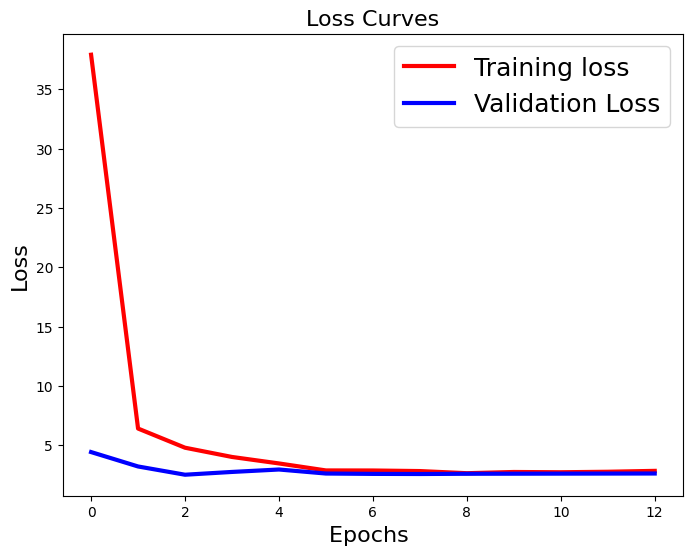

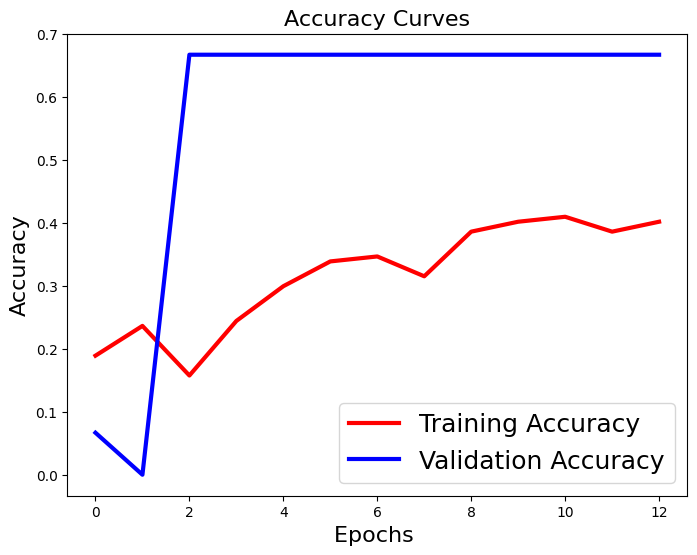

In [106]:
# See the performance of the model!
visualize_performance(history)

In [118]:
def visualize_vehicles_with_viewpoint(car_detection_model, viewpoint_model, img_file):
    # Load original image file and put it in the correct format
    img = Image.open(img_file)
    img_np = np.array(img)

    # Run car detection model to get bounding boxes
    results = car_detection_model.predict(img_file)

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(img_np)

    # Iterate through each bounding box
    for result in results:
        for box in result.boxes:
            # Get the box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

            # Get the class ID and confidence
            class_id = int(box.cls.item())
            confidence = box.conf.item()

            # Check if the detected object is a car, truck, van
            if (class_id == 0 or class_id == 2 or class_id == 4) and confidence > 0.5:
                # Crop car patch from image
                patch = img_np[y1:y2, x1:x2]

                # Resize patch to match the input size expected by the viewpoint model
                patch = cv2.resize(patch, (100, 100))
                patch = np.expand_dims(patch, axis=0)  # Add batch dimension

                # Calculate height and width of the car
                height = np.expand_dims(np.array([y2 - y1]), axis=0)
                width = np.expand_dims(np.array([x2 - x1]), axis=0)

                # Get the predicted viewpoint probabilities for this car
                probabilities = viewpoint_model.predict([patch, height, width])

                # Find the class with the highest probability
                prediction = np.argmax(probabilities)

                # Calculate the angle from the prediction
                angle_degrees = prediction * 30

                # Draw the bounding box with the corresponding color on the image
                class_name = next(key for key, value in class_mapping.items() if value == class_id)
                color = class_colors[class_name]
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                # Add text label with class name and confidence
                label = f'{class_name} {confidence:.2f}'
                ax.text(x1, y1 - 5, label, color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

                # Visualize the car bounding box and angle
                center_x, center_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
                plt.arrow(center_x, center_y, np.cos(np.deg2rad(angle_degrees)) * 20, -np.sin(np.deg2rad(angle_degrees)) * 20, color='w', linewidth=2, head_width=20, head_length=2)
                plt.text(center_x, center_y, f'{angle_degrees}°', fontsize=12, color='lime')
                ax.add_patch(rect)

    plt.show()


In [108]:
# load the trained YOLOv8 model for car detection
car_detection_model = YOLO('/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_2_CAR_DETECTION/train/weights/best.pt')

In [114]:
# load the trained viewpoint model
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/MODEL_1_VIEWPOINT'
viewpoint_model = load_model(model_path)

### 8. Show a test image with the detected car bounding boxes and show the estimated viewpoints by plotting an arrow in the appropriate direction


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images/001773.png: 224x640 10 Cars, 110.6ms
Speed: 2.5ms preprocess, 110.6ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 640)
1/1 [==============================] - 0s 40ms/step


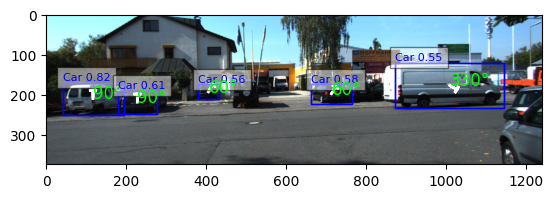

In [120]:
# Check predictions!
# Path to the image file
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/images/001773.png'

# Visualize cars with predicted viewpoints
visualize_vehicles_with_viewpoint(car_detection_model, viewpoint_model, img_file)


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/000051.png: 224x640 2 Cars, 1 Van, 116.5ms
Speed: 2.2ms preprocess, 116.5ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
1/1 [==============================] - 0s 63ms/step


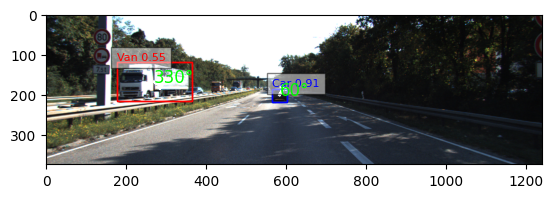

In [121]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/000051.png'
# Visualize cars with predicted viewpoints
visualize_vehicles_with_viewpoint(car_detection_model, viewpoint_model, img_file)


image 1/1 /content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/001267.png: 224x640 7 Cars, 74.8ms
Speed: 1.7ms preprocess, 74.8ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 640)
1/1 [==============================] - 0s 36ms/step


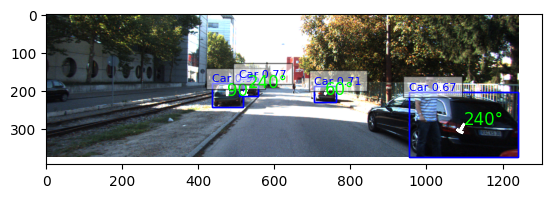

In [122]:
img_file = '/content/drive/MyDrive/CSC420_FINAL/object_detection_dataset/test/other_cases/001267.png'
# Visualize cars with predicted viewpoints
visualize_vehicles_with_viewpoint(car_detection_model, viewpoint_model, img_file)